## 18.337 Midterm Project: Isotonic Regression in Julia

## Author: Hanzhang Qin

In [1]:
#Pkg.add("Isotonic")
using Isotonic, PyPlot

Qt: Untested Windows version 10.0 detected!


Isotonic regression is a regression problem with (partial) order constraints on the estimaters. Cast in a $L_2$ formulation, it can be treated as a Quadratic Programming (QP) problem in general. See below.

Given a vector $a\in \mathbb{R}^n$ and a directed graph $G=(N,E)$ we want to solve:

$\min_{x\in \mathbb{R}^n} \sum_{i=1}^{n} w_i (x_i-a_i)^2 $ subject to $x_i\leq x_j$ for all $(i,j)\in E$.

## Simply Ordered Case

Simple order means the $x_i\leq x_j$ constraints are $x_1\leq x_2\leq \ldots \leq x_n$.

It turns out this is the only scenario the package Isotonic.jl is able to do! And it defaultly implements the simple, fast, powerful Pool-Adjacent-Violaters Algorithm (PAVA). 

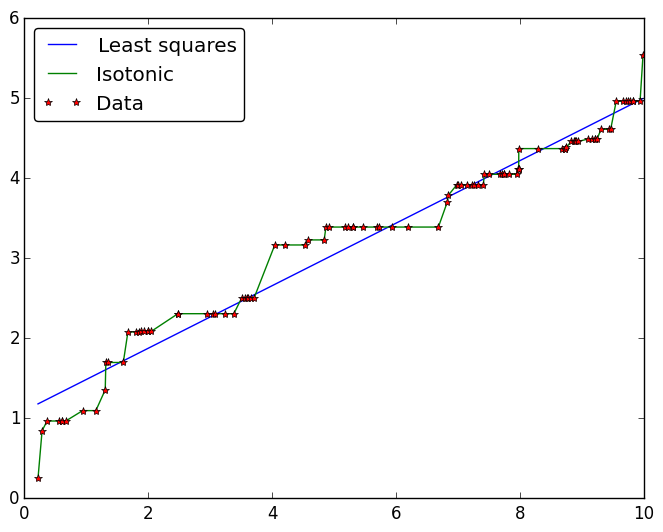

PyObject <matplotlib.legend.Legend object at 0x000000001F153CF8>

In [25]:
# A synthetic dataset example
X = sort(vec(rand(100,1))*10)
Y = 1.5*X.^0.5 .+ randn(100,1)/3
least_square_sol = [vec(ones(100,1)) X]*([vec(ones(100,1)) X]'*[vec(ones(100,1)) X])^(-1)*[vec(ones(100,1)) X]'*Y
isotone_sol = isotonic_regression(vec(Y))
plot(X,least_square_sol,label="Least squares")
plot(X,isotone_sol,label="Isotonic")
plot(X,Y,"*",label="Data")
legend(loc="upper left",fancybox="true")

In [43]:
# Timing comparison for the two PAVA methods
using BenchmarkTools
Data_size = [1e2,1e3,1e4,1e5,1e6,1e7]
Time_l_PAVA = []
Time_p_PAVA = []
Time_active = []
for n in Data_size
    temp1 = []
    temp2 = []
    temp3 = []
    for t = 1:5
        X = sort(vec(rand(Int64(n),1))*10)
        Y = 1.5*X.^0.5 .+ randn(Int64(n),1)/3
        tic();
        isotonic_regression(vec(Y))
        push!(temp1, toq())
        X = sort(vec(rand(Int64(n),1))*10)
        Y = 1.5*X.^0.5 .+ randn(Int64(n),1)/3
        tic();
        pooled_pava_isotonic_regression(vec(Y))
        push!(temp2, toq())
        #X = sort(vec(rand(Int64(n),1))*10)
        #Y = 1.5*X.^0.5 .+ randn(Int64(n),1)/3
        #tic();
        #active_set_isotonic_regression(vec(Y))
        #push!(temp3, toq())
    end
    push!(Time_l_PAVA,mean(temp1))
    push!(Time_p_PAVA,mean(temp2))
    #push!(Time_active,mean(temp3))
end

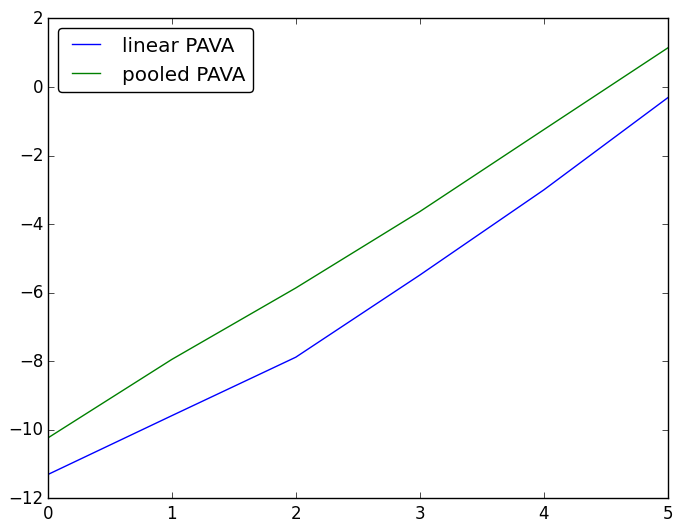

PyObject <matplotlib.legend.Legend object at 0x000000001E8E0EB8>

In [50]:
# Clearly pooled PAVA is not uesful, you should always use linear PAVA by default
plot(log(convert(Array{Float64,1},Time_l_PAVA) ),label="linear PAVA" )
plot(log(convert(Array{Float64,1},Time_p_PAVA) ),label="pooled PAVA" )
legend(loc="upper left",fancybox="true")

## More intuition about (linear) PAVA

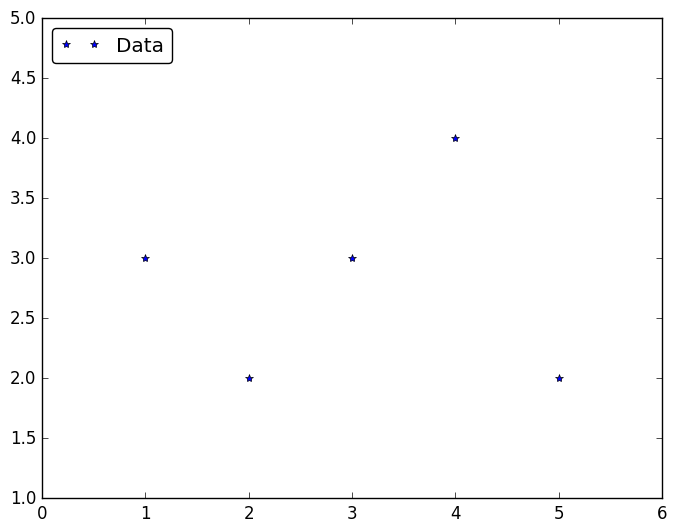

In [2]:
# Consider a simple example
X = [1;2;3;4;5];
Y = [3;2;3;4;2.];
w =[1;1;1;1;1];
plot(X,Y,"*",label="Data")
legend(loc="upper left",fancybox="true")
ax = gca() # get current axes
ax[:set_xlim]((0,6));
ax[:set_ylim]((1,5));

PAVA is composed of two operations: "scan" and "merge";

Taking "group" averages from left to right, as long as the isotonic constraint is not violated, otherwise merge groups;

The number of "scan" and "merge" operations is O(n).

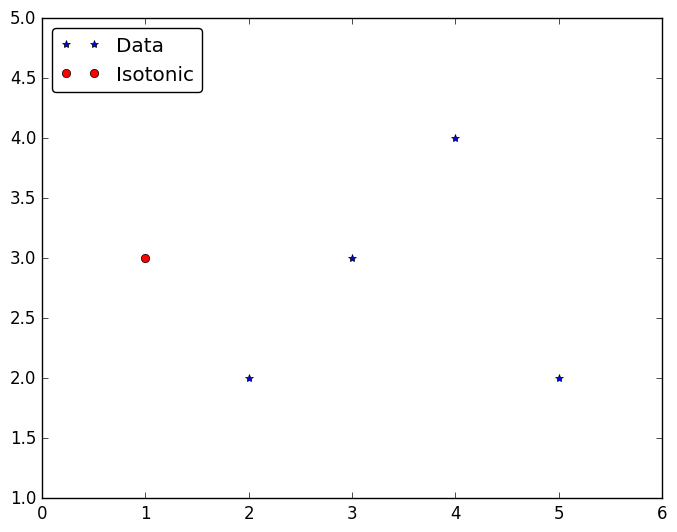

In [3]:
# First step: data 1 as a singleton group
G = [[1]];
plot(X,Y,"*",label="Data")
plot(X[1],Y[1],"o",label="Isotonic",color="red")
legend(loc="upper left",fancybox="true")
ax = gca() # get current axes
ax[:set_xlim]((0,6));
ax[:set_ylim]((1,5));

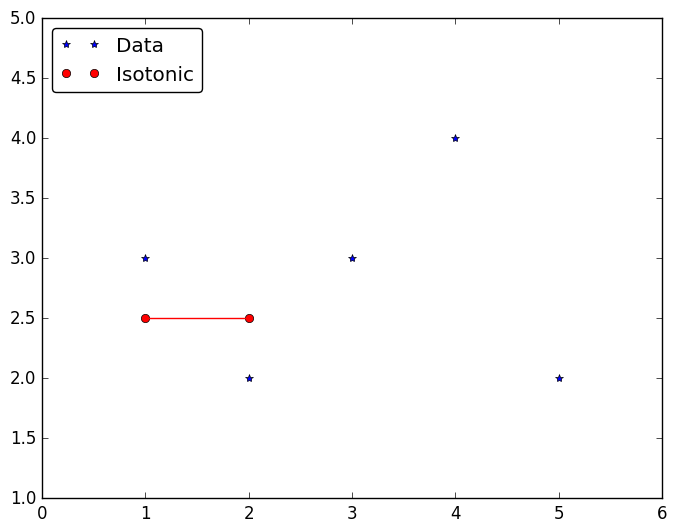

In [4]:
# Second step: since Y[2] < mean([1]), we merge Y[1] and Y[2] to form a new group
G = [[1,2]];
plot(X,Y,"*",label="Data")
plot([X[1];X[2]],[(Y[1]+Y[2])/2;(Y[1]+Y[2])/2],"o",label="Isotonic",color="red")
plot( [X[1];X[2]],[(Y[1]+Y[2])/2;(Y[1]+Y[2])/2],color="red")
legend(loc="upper left",fancybox="true")
ax = gca() # get current axes
ax[:set_xlim]((0,6));
ax[:set_ylim]((1,5));

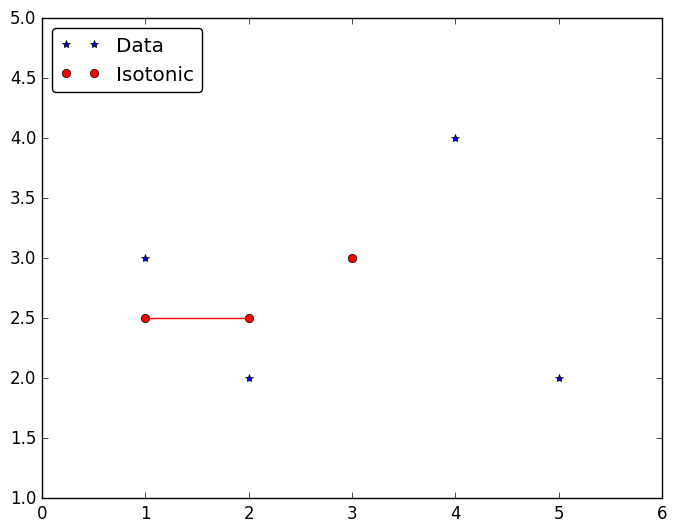

In [5]:
# Third step: since Y[3] > mean([1,2]), no merge needed, data 3 becomes a new singleton group
G = [[1,2]];
plot(X,Y,"*",label="Data")
plot([X[1];X[2];X[3]],[(Y[1]+Y[2])/2;(Y[1]+Y[2])/2;Y[3]],"o",label="Isotonic",color="red")
plot( [X[1];X[2]],[(Y[1]+Y[2])/2;(Y[1]+Y[2])/2],color="red")
legend(loc="upper left",fancybox="true")
ax = gca() # get current axes
ax[:set_xlim]((0,6));
ax[:set_ylim]((1,5));

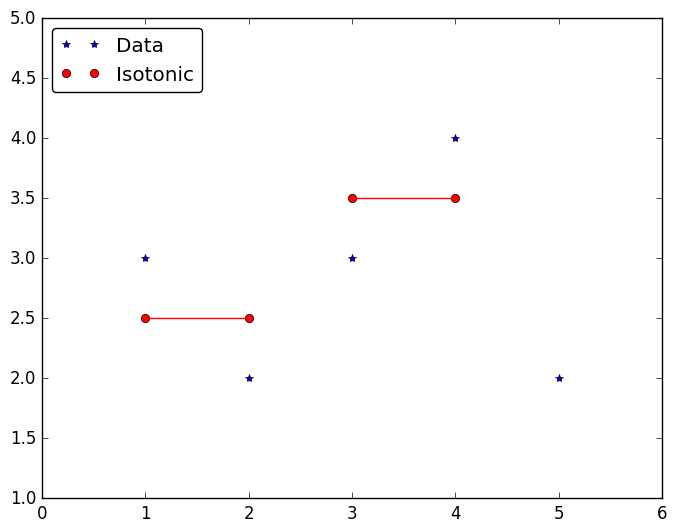

In [6]:
# Fourth step: since Y[4] > mean([3]), we merge data 3 and data 4 to form a new group
# Note: after the merge, if mean([1,2]) > mean([3,4]), we need to merge all the 4 points to form [1,2,3,4] as a new group!
G = [[1,2]];
plot(X,Y,"*",label="Data")
plot([X[1];X[2];X[3];X[4]],[(Y[1]+Y[2])/2;(Y[1]+Y[2])/2;(Y[3]+Y[4])/2;(Y[3]+Y[4])/2;],"o",label="Isotonic",color="red")
plot([X[1];X[2]],[(Y[1]+Y[2])/2;(Y[1]+Y[2])/2],color="red")
plot([X[3];X[4]],[(Y[3]+Y[4])/2;(Y[3]+Y[4])/2],color="red")
legend(loc="upper left",fancybox="true")
ax = gca() # get current axes
ax[:set_xlim]((0,6));
ax[:set_ylim]((1,5));

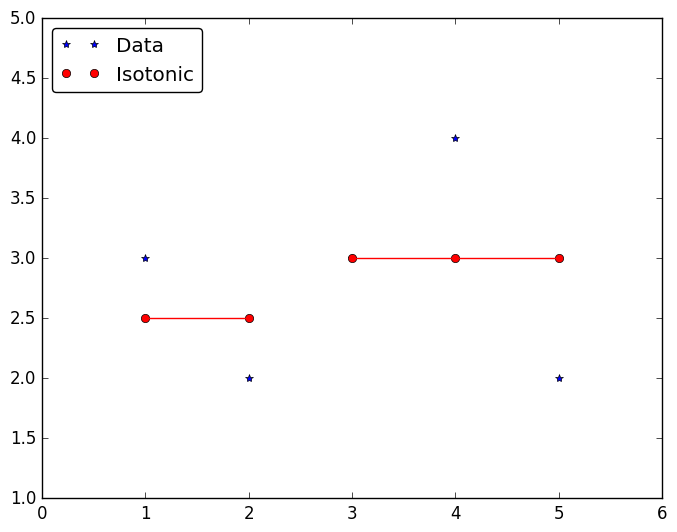

In [7]:
# Fifth step: since Y[5] > mean([3,4]), we merge and obtain [3,4,5] as a new group
# Note: after the merge, if mean([3,4,5]) > mean([1,2]), we need to merge all the 5 points to form [1,2,3,4,5] as a new group!
G = [[1,2]];
plot(X,Y,"*",label="Data")
plot([X[1];X[2];X[3];X[4];X[5]],[(Y[1]+Y[2])/2;(Y[1]+Y[2])/2;(Y[3]+Y[4]+Y[5])/3;(Y[3]+Y[4]+Y[5])/3;(Y[3]+Y[4]+Y[5])/3],"o",label="Isotonic",color="red")
plot([X[1];X[2]],[(Y[1]+Y[2])/2;(Y[1]+Y[2])/2],color="red")
plot([X[3];X[4];X[5]],[(Y[3]+Y[4]+Y[5])/3;(Y[3]+Y[4]+Y[5])/3;(Y[3]+Y[4]+Y[5])/3],color="red")
legend(loc="upper left",fancybox="true")
ax = gca() # get current axes
ax[:set_xlim]((0,6));
ax[:set_ylim]((1,5));

Hence, the solution for this simple problem is [2.5,2.5,3,3,3]. 

In [176]:
# Using the previous ideas, the linear PAVA can be written as follows.
@everywhere function isotonic_regression!(y::Vector{Float64}, weights::Vector{Float64})
    n = length(y)
    if n <= 1
        return y
    end
    if n != length(weights)
        throw(DimensionMismatch("Lengths of values and weights mismatch"))
    end

    @inbounds begin
        n -= 1
        while true
            i = 1
            pooled = 0
            while i <= n
                k = i
                while k <= n && y[k] >= y[k+1]
                    k += 1
                end

                # Find a decreasing subsequence, and update
                # all points in the sequence to the weighted average.
                if y[i] != y[k]
                    numerator = 0.0
                    denominator = 0.0
                    for j in i : k
                        numerator += y[j] * weights[j]
                        denominator += weights[j]
                    end

                    for j in i : k
                        y[j] = numerator / denominator
                    end
                    pooled = 1
                end
                i = k + 1
            end
            if pooled == 0
                break
            end
        end
    end
    return y
end

isotonic_regression!(y::Vector{Float64}) = isotonic_regression!(y, ones(size(y, 1)))

# non-mutating versions
isotonic_regression(y::Vector{Float64}, weights::Vector{Float64}) = isotonic_regression!(copy(y), weights)
isotonic_regression(y::Vector{Float64}) = isotonic_regression(y, ones(size(y,1)))

isotonic_regression (generic function with 2 methods)

}, Array{Float64, 1}) in module Main at In[8]:3 overwritten at In[176]:3.


## Parallel PAVA!

From the previous discussions, it is quite clear that PAVA can be written into a map-reduce fashion, which means it can be paralleled.

To be specific, consider doing two small PAVA in parallel and obtain $Y_1$ which satisfies $y_1\leq y_2\leq \ldots y_k$ and $Y_2$ which satisfies $y_k\leq y_{k+1}\leq \ldots y_n$.

If $y_k\leq y_{k+1}$, then $[Y_1,Y_2]$ is isotonic and we are done; 

Otherwise, denote $m=\min\{ i:y_i>y_{k+1} \}$, $M=\max\{ i:y_i<y_k \}$, we replace all the annoying $y_i$ by $\bar{y}=\sum_{i=m}^Mw_iy_i/\sum_{i=m}^Mw_i$. Then $Y=[Y_1,Y_2]$ is the optimal isotonic $Y$.

In [177]:
@everywhere function isotonic_merge(Y1,w1,Y2,w2)
    if length(find(Y1.>Y2[1]))>0
        m = find(Y1.>Y2[1])[1]
        M = find(Y2.<Y1[end])[end]
        y_bar = sum([Y1[m:end].*w1[m:end];Y2[1:M].*w2[1:M]])/sum([w1[m:end];w2[1:M]])
        Y1[m:end] = y_bar*vec(ones(length(Y1)-m+1,1))
        Y2[1:M] = y_bar*vec(ones(M,1))
    end
    return [Y1;Y2]
end

isotonic_merge(Y1,Y2) = isotonic_merge(Y1, ones(size(Y1,1)), Y2, ones(size(Y2,1)))

isotonic_merge (generic function with 2 methods)

(Any, Any) in module Main at In[96]:12 overwritten at In[177]:12.


In [62]:
# A simple demo for the merging step
isotonic_merge([1.;3;5],[2.;4;6])

6-element Array{Float64,1}:
 1.0
 3.5
 3.5
 3.5
 3.5
 6.0

In [120]:
@everywhere using DistributedArrays

In [115]:
nprocs() == 1 && addprocs(4)

4-element Array{Int64,1}:
 2
 3
 4
 5

In [178]:
# Create a distributed array
Y = 10*drand(40);

In [179]:
# Stored separately on 4 workers
[DistributedArrays.chunk(Y, i) for i = 1:4]

4-element Array{Array{Float64,1},1}:
 [7.37815,9.69133,1.24843,3.89601,5.22644,5.56937,3.22155,2.83808,9.86755,3.03267]  
 [1.68191,7.52853,4.51794,0.174643,1.44295,3.31457,8.49226,7.69654,5.45431,2.56089] 
 [8.13258,7.11164,5.01039,1.82199,7.41658,6.32573,7.97168,0.0658407,5.96329,3.57928]
 [8.66509,5.56694,8.24836,4.03854,7.99881,7.65706,2.39337,1.54194,9.26653,1.18569]  

In [180]:
Y1 = Y[1:10];
Y2 = Y[11:20];
Y3 = Y[21:30];
Y4 = Y[31:40];

In [181]:
Y = Vector{Float64}[Y1,Y2,Y3,Y4];

In [182]:
Z = map((t) -> isotonic_regression!(t),Y)

4-element Array{Array{Float64,1},1}:
 [4.88367,4.88367,4.88367,4.88367,4.88367,4.88367,4.88367,4.88367,6.45011,6.45011]
 [1.68191,3.39573,3.39573,3.39573,3.39573,3.39573,6.051,6.051,6.051,6.051]        
 [5.3399,5.3399,5.3399,5.3399,5.3399,5.3399,5.3399,5.3399,5.3399,5.3399]          
 [5.65623,5.65623,5.65623,5.65623,5.65623,5.65623,5.65623,5.65623,5.65623,5.65623]

In [183]:
isotonic_merge(isotonic_merge(isotonic_merge(Z[1],Z[2]),Z[3]),Z[4])'

1×40 Array{Float64,2}:
 4.74171  4.74171  4.74171  4.74171  …  5.65623  5.65623  5.65623  5.65623

## Extension 1 of PAVA: 1D Convex/Concave Regression

In a 1D convex regression problem, given a vector $a\in \mathbb{R}^n$, we want to solve:

$\min_{f\in \mathbb{R}^n} \sum_{i=1}^{n} w_i (f_i-a_i)^2 $ subject to $\frac{f_{i+1}-f_i}{x_{i+1}-x_i}$ is monotonically nondecreasing.

By changing varialbe as $z_i = \frac{f_{i+1}-f_i}{x_{i+1}-x_i}$, we can apply projected gradient descent algorithm to solve the convex regression problem. It is clear the projection step can be done by PAVA.

In [187]:
function uni_regression(X, Y, option, MaxIter = 10000, err = 1e-3, lam = 1)
# (X,Y) is 1-D data, option = "convex" means convex regression, "concave" means concave regression, lam is the regularizer
# L is Lipshitz constant
n = size(Y,1)
L = n * 10
Z_prev = vec(zeros(n,1));
Z_cur = vec(zeros(n,1));
phi_best = []
# Iter records the number of iterations the algorithm uses until it converges
Iter = MaxIter;
phi = vec(zeros(n,1));
obj_best = 1e10
obj_seq = []
# Coordinate descent
for t = 1:MaxIter      
    df = vec(zeros(n,1));
    temp = vec(zeros(n,1));
    temp[1] = Z_prev[1];
    for i = 2:n
        temp[i] = temp[i-1]+Z_prev[i]*(X[i]-X[i-1]);
    end
    df[1] = 2*(sum(temp)-sum(Y));
    df[2] = 2*(X[2]-X[1])*(df[1]/2-temp[1]+Y[1]);    
    for i = 2:n-1
         df[i+1] = 2*(X[i+1]-X[i])*(df[i]/2/(X[i]-X[i-1])-temp[i]+Y[i]);
    end
    for j = 1:n
        if Z_prev[j] > 0
           df[j] = df[j] + lam
        end
        if Z_prev[j] < 0
           df[j] = df[j] - lam
        end
    end
    Z_cur[1] = Z_prev[1]-df[1]/L;
    if option == "convex"
        Z_cur[2:n] = isotonic_regression(vec(Z_prev[2:n]-df[2:n]/L)[:] );
    elseif option == "concave"
        Z_cur[n:-1:2] = isotonic_regression(vec(Z_prev[n:-1:2]-df[n:-1:2]/L)[:] );
    else
        error("Invalid option value!")
    end 
    if sum(abs(vec(Z_cur-Z_prev))) < err
        Iter = t+1;
        break
    else
        Z_prev = vec(Z_cur)[:];        
    end
    # Retrieve optimal solutions by changing the variables back   
    z = vec(Z_cur);
    phi[1] = z[1];
    for j = 2:n
        phi[j] = z[j]*(X[j]-X[j-1])+phi[j-1];
    end
    if sum(vec(phi-Y).^2) < obj_best
        obj_best = sum(vec(phi-Y).^2)
        phi_best = phi
    end
    push!(obj_seq, sum(obj_best) )   
end
    return phi_best, obj_seq
end

uni_regression (generic function with 4 methods)

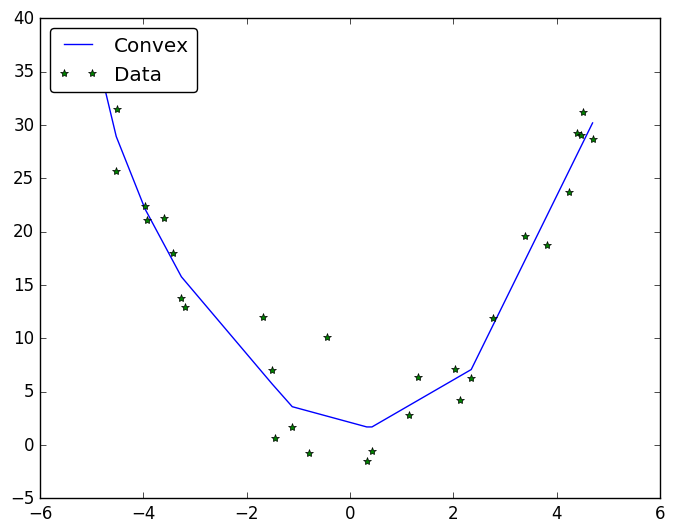

PyObject <matplotlib.legend.Legend object at 0x00000000249E8208>

In [193]:
X = sort(vec(rand(30,1))*10)-5
Y = 1.5*X.^2 .+ randn(30,1)*3
convex_sol, obj = uni_regression(X,Y,"convex")
plot(X,convex_sol,label="Convex")
plot(X,Y,"*",label="Data")
legend(loc="upper left",fancybox="true")

## Extension 2 of PAVA: Unimodal (K-modal) Regression

Another extension of the isotonic regression problem is to relax the isotonic constraints $x_1\leq x_2\leq \ldots \leq x_n$ as:

$x_1\leq x_2\leq \ldots \leq x_{j^*}\geq  x_{j^*+1}\geq \ldots x_n$ for some $j^*$, i.e., the solution can have at most one mode. 

It turns out this problem also admits a PAVA solution, the only price is we need to store the solution for PAVA's each scan!

In [1]:
immutable ActiveState
    weighted_label::Float64
    weight::Float64
    lower::Int64
    upper::Int64

end

function merge_state(l::ActiveState, r::ActiveState)
        return ActiveState(l.weighted_label + r.weighted_label,
                           l.weight + r.weight,
                           l.lower,
                           r.upper)
end

function below(l::ActiveState, r::ActiveState)
    return l.weighted_label * r.weight <= l.weight * r.weighted_label
end

function active_set_unimodal_regression(y::Vector{Float64}, weights::Vector{Float64})
    min_index = -1
    min_err = 10e8
    opt_w = zeros(size(y, 1),1)
    W=zeros(size(y, 1)+1,size(y, 1))
    err_left=zeros(size(y,1)+1,1)
    err_right=zeros(size(y,1)+1,1)
        
    active_set = Array(ActiveState, size(y, 1))  
    
    for k in 1 : size(active_set, 1)
            active_set[k] = ActiveState(weights[k] * y[k], weights[k], k, k)
    end
    
    current = 0
    for i = 1:size(y, 1)
        if i==1
            current += 1
        else
            if below(active_set[current], active_set[current+1])
                current += 1
            else
                merged = merge_state(active_set[current], active_set[current+1])
                splice!(active_set, current:current+1, [merged])
                while current > 1 && !below(active_set[current-1], active_set[current]) 
                    current -= 1
                    merged = merge_state(active_set[current], active_set[current+1])
                    splice!(active_set, current:current+1, [merged])
                end
            end 
        end
        for as in active_set
            if as.lower > i
                break
            else
                W[i+1,as.lower:as.upper] = as.weighted_label / as.weight
            end
        end  
        err_left[i+1] = sum((W[i+1,1:i]'-y[1:i] ).^2)
    end
    
    active_set = Array(ActiveState, size(y, 1))  
    
    for k in 1 : size(active_set, 1)
        active_set[k] = ActiveState(weights[size(y, 1) - k + 1] * y[size(y, 1) - k + 1], weights[size(y, 1) - k + 1], k, k)
    end
    
    current = 0
    for i = 1:size(y, 1)
        if i==1
            current += 1
        else
            if below(active_set[current], active_set[current+1])
                current += 1
            else
                merged = merge_state(active_set[current], active_set[current+1])
                splice!(active_set, current:current+1, [merged])
                while current > 1 && !below(active_set[current-1], active_set[current]) 
                    current -= 1
                    merged = merge_state(active_set[current], active_set[current+1])
                    splice!(active_set, current:current+1, [merged])
                end
            end 
        end
        for as in active_set
            if as.lower > i
                break
            else
                W[size(y, 1) - i + 1, size(y, 1) - as.upper + 1:size(y, 1) - as.lower + 1] = as.weighted_label / as.weight
            end
        end  
        err_right[size(y, 1) - i + 1] =
        sum((W[size(y, 1) - i + 1, size(y, 1) - i + 1: size(y, 1)]'-y[size(y, 1) - i + 1: size(y, 1)] ).^2)
        
        if err_right[size(y, 1) - i + 1] + err_left[size(y, 1) - i + 1] < min_err
            min_err = err_right[size(y, 1) - i + 1] + err_left[size(y, 1) - i + 1]
            min_index = size(y, 1) - i + 1
            opt_w = W[size(y, 1) - i + 1, :]'
        end
    end
    
    return min_err, opt_w
end

active_set_unimodal_regression(y::Vector{Float64}) = active_set_unimodal_regression(y, ones(size(y, 1)))

active_set_unimodal_regression (generic function with 2 methods)

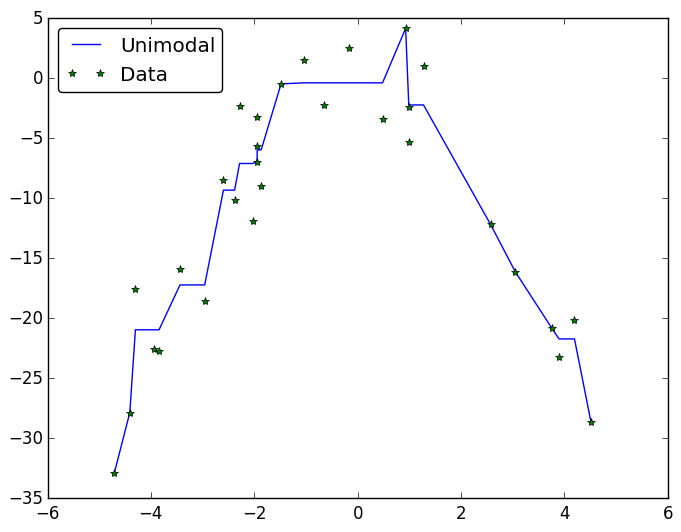

PyObject <matplotlib.legend.Legend object at 0x000000001C80C668>

In [5]:
using PyPlot
X = sort(vec(rand(30,1))*10)-5
Y = -1.5*X.^2 .+ randn(30,1)*3
obj2, unimodal_sol = active_set_unimodal_regression(vec(Y))
plot(X,unimodal_sol,label="Unimodal")
plot(X,Y,"*",label="Data")
legend(loc="upper left",fancybox="true")

It is straightforward to generalize this idea to $K$-modal regression, for any $K\geq 1$.

## Extension 3 of PAVA: Shape-restricted Density Estimation, Multivariate Separable Convex/Concave Regression...

These are my ongoing research topics, will probably report them in the final project!